## **Estudio empírico de las acciones con alta volatilidad en EE.UU.**

-En los mercados financieros, las **small caps** —empresas de pequeña capitalización— son conocidas por su **alta volatilidad** y sus **movimientos extremos en periodos cortos de tiempo**. Estas acciones suelen protagonizar las mayores subidas intradía, impulsadas por noticias, euforia o especulación minorista. Sin embargo, detrás de esas explosiones momentáneas, se esconde un patrón que muchos analístas financieros sospechan desde hace años:

*   *"Las small caps tienden, estadísticamente, a perder valor con el tiempo tras movimientos extremos al alza."*

-Este estudio busca poner a prueba esa teoría de forma empírica, analizando miles de observaciones de acciones que tuvieron una gran extensión en un solo día.

-El objetivo es identificar si existe un **sesgo bajista sistemático** posterior a estos impulsos —es decir, si el comportamiento colectivo de las small caps muestra una **asimetría negativa** tras grandes subidas, y si ese fenómeno puede considerarse un **edge estadístico aprovechable** en estrategias de corto plazo.


**Para empezar, importamos las librerias que utilizaremos para este análisis**

In [17]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

## **Lectura del dataset**

-El dataset *market_extensions* reúne información detallada de precios, volúmenes y métricas intradía (desde 2022 a 2025) de los principales “runners” del mercado estadounidense, abarcando tanto valores del NASDAQ como del NYSE. Entendiendo como "runners" aquellas acciones que se extendieron más de +20 % en un solo día.

-Fuente de la data: https://www.runstocks.com/

### Diccionario de columnas:

* 01 Date – Fecha del evento. Día en que la acción se extendió +20 % (ya sea en premarket o sesión regular).

* 02 Ticker – Símbolo bursátil. La “matrícula” de la acción.

* 03 Open Gap % – Diferencia porcentual entre el precio de apertura y el cierre del día anterior. Indica si abrió con gap alcista o bajista.

* 04 RTH Run % – Porcentaje de avance desde la apertura hasta el máximo durante el horario regular (RTH). Mide la fuerza del movimiento intradía.

* 05 EOD Volume – Volumen total negociado al cierre del día. Un buen proxy de interés y liquidez.

* 06 Day Return % – Rentabilidad diaria desde el precio de apertura hasta el cierre.

* 07 Open Price – Precio de apertura oficial en el mercado regular.

* 08 Close Price – Precio de cierre oficial del día.

* 09 Previous Day Close Price – Precio de cierre del día anterior. Sirve para calcular el gap inicial.

* 10 Pre-Market High Price – Precio máximo alcanzado en premarket. Puede faltar si no hubo datos premarket relevantes.

* 11 High Spike Price – El pico máximo intradía (en RTH). Donde normalmente se produce el “blow-off top”.

* 12 Low Spike Price – El mínimo intradía (en RTH). El extremo inferior del rango diario.

* 13 Premarket Volume – Volumen negociado antes de la apertura (pre-market).

* 14 PMH Gap % – Porcentaje de diferencia entre el pre-market high y el cierre previo. Mide la extensión total premarket.

* 15 PMH Fade to Open % – Cuánto retrocede el precio desde el pre-market high hasta la apertura. Señal de debilidad inicial.

* 16 RTH Fade to Close % – Retroceso desde el máximo intradía hasta el cierre. Indica si la subida se sostuvo o se desinfló.

* 17 RTH Range % – Rango porcentual entre el máximo y el mínimo intradía. Refleja la volatilidad del día.

* 18 High Spike % – Extensión porcentual desde la apertura hasta el máximo (similar a RTH Run %, pero puede incluir PM).

* 19 Low Spike % – Movimiento porcentual desde la apertura hasta el mínimo. Si es grande, probablemente hubo flush.

* 20 HOD Time – “Hour of Day” del máximo (High of Day). Momento exacto del pico intradía.

* 21 LOD Time – “Hour of Day” del mínimo (Low of Day). Momento exacto del suelo intradía.

* 22 PM High Time – Hora del máximo premarket (si existió). Vacío en días sin actividad PM relevante.

In [18]:
stocks = pd.read_csv(r'market_extension.csv') #Versión original
stocks_v1 = pd.read_csv(r'market_extension.csv') #Versión original que vamos a formatear

**Realizamos una pre-visualización del contenido**

In [19]:
print(stocks.shape)
stocks.head()

(37428, 23)


,Date,Ticker,Open Gap %,RTH Run %,EOD Volume,Day Return %,Open Price,Low Spike Price,Close Price,Previous Day Close Price,...,PMH Gap %,PMH Fade to Open %,RTH Fade to Close %,RTH Range %,High Spike %,Low Spike %,HOD Time,LOD Time,PM High Time,VWAP at Open
0,2025-11-07,AAOI,-0.140893,0.210000,10118549,0.142800,25.00,24.76,28.57,29.10,...,-0.113402,-0.031008,-0.055537,0.221729,0.210000,-0.009600,09:47,09:30,06:53,25.69
1,2025-11-07,ABAT,-0.024390,0.245833,15684760,0.230556,3.60,3.60,4.43,3.69,...,0.037940,-0.060052,-0.012263,0.245833,0.245833,0.000000,15:54,09:30,08:00,3.66
2,2025-11-07,AHMA,0.049296,0.268456,1031167,0.134228,4.47,4.45,5.07,4.26,...,0.072770,-0.021882,-0.105820,0.273871,0.268456,-0.004251,13:58,09:36,09:18,4.27
3,2025-11-07,AMTX,-0.005682,0.202857,1324214,0.200000,1.75,1.74,2.10,1.76,...,0.022727,-0.027778,-0.002375,0.213256,0.202857,-0.008571,15:53,09:30,08:35,1.76
4,2025-11-07,AREC,-0.060942,0.227139,12875571,0.182891,3.39,3.39,4.01,3.61,...,0.000000,-0.060942,-0.036058,0.227139,0.227139,0.000000,14:13,09:30,08:00,3.49


**Realizamos algunos formateos a los datos y eliminamos variables que no se van
a utilizar por el momento**

In [20]:
stocks_v1['Date'] = pd.to_datetime(stocks_v1['Date'], errors='coerce')
stocks_v1['Period'] = stocks_v1['Date'].dt.year
stocks_v1['Month'] = stocks_v1['Date'].dt.month
stocks_v1['Week'] = stocks_v1['Date'].dt.isocalendar().week

stocks_v1.drop(['EOD Volume', 'RTH Run %','Low Spike Price','Pre-Market High Price', 'High Spike Price','PMH Gap %','PMH Fade to Open %',
                'RTH Fade to Close %', 'High Spike %', 'Low Spike %', 'HOD Time', 'LOD Time', 'PM High Time', 'VWAP at Open', 'Previous Day Close Price'],
                 axis = 'columns',
                 inplace=True)

stocks_v1.head()

,Date,Ticker,Open Gap %,Day Return %,Open Price,Close Price,Premarket Volume,RTH Range %,Period,Month,Week
0,2025-11-07,AAOI,-0.140893,0.142800,25.00,28.57,601934,0.221729,2025,11,45
1,2025-11-07,ABAT,-0.024390,0.230556,3.60,4.43,245207,0.245833,2025,11,45
2,2025-11-07,AHMA,0.049296,0.134228,4.47,5.07,930631,0.273871,2025,11,45
3,2025-11-07,AMTX,-0.005682,0.200000,1.75,2.10,7618,0.213256,2025,11,45
4,2025-11-07,AREC,-0.060942,0.182891,3.39,4.01,239782,0.227139,2025,11,45


### **Proceso de Limpieza y Filtrado del Dataset**

Realizamos varios filtros para quedarnos con una muestra útil (buscamos small caps):


*   Evitar "buyouts": eliminar tickers con muy poca volatilidad intradía usando RTH Range % < 10%, ya que suelen ser adquisiciones con precio congelado.
*   Filtrar small caps: descartar acciones grandes usando el precio como proxy, por ejemplo eliminando valores con precio > 12 USD.
*   Filtrar liquidez: exigir un volumen mínimo en premarket de ≥ 1.000.000 para evitar tickers sin actividad real.
*   Filtrar relevancia operativa: mantener solo acciones con Open Gap % ≥ 50% (positivo) para asegurar que hubo un movimiento significativo.

In [21]:
def filtrar_smallcaps(stocks_v1):
  filtro_no_buyouts = stocks_v1['RTH Range %'] > 0.1
  filtro_smallcaps = stocks_v1['Open Price'] < 12
  filtro_liquidez = stocks_v1['Premarket Volume'] > 1000000
  filtro_gap = stocks_v1['Open Gap %'] > 0.5

  filtros = (
      filtro_no_buyouts &
      filtro_smallcaps &
      filtro_liquidez &
      filtro_gap
  )

  return stocks_v1[filtros].copy()

In [22]:
stocks_filtrados = filtrar_smallcaps(stocks_v1)
stocks_filtrados.head()

,Date,Ticker,Open Gap %,Day Return %,Open Price,Close Price,Premarket Volume,RTH Range %,Period,Month,Week
7,2025-11-07,AZI,0.544073,-0.378609,0.15,0.09,153766627,0.691454,2025,11,45
22,2025-11-07,MSGM,1.079909,-0.178924,4.55,3.74,49778163,0.541059,2025,11,45
43,2025-11-06,BIYA,0.942370,-0.107669,0.54,0.48,140140698,0.815919,2025,11,45
51,2025-11-06,FTEL,0.535967,-0.557185,3.41,1.51,32940762,1.406897,2025,11,45
80,2025-11-05,CCTG,1.024078,-0.633604,1.69,0.62,1490486,2.188113,2025,11,45


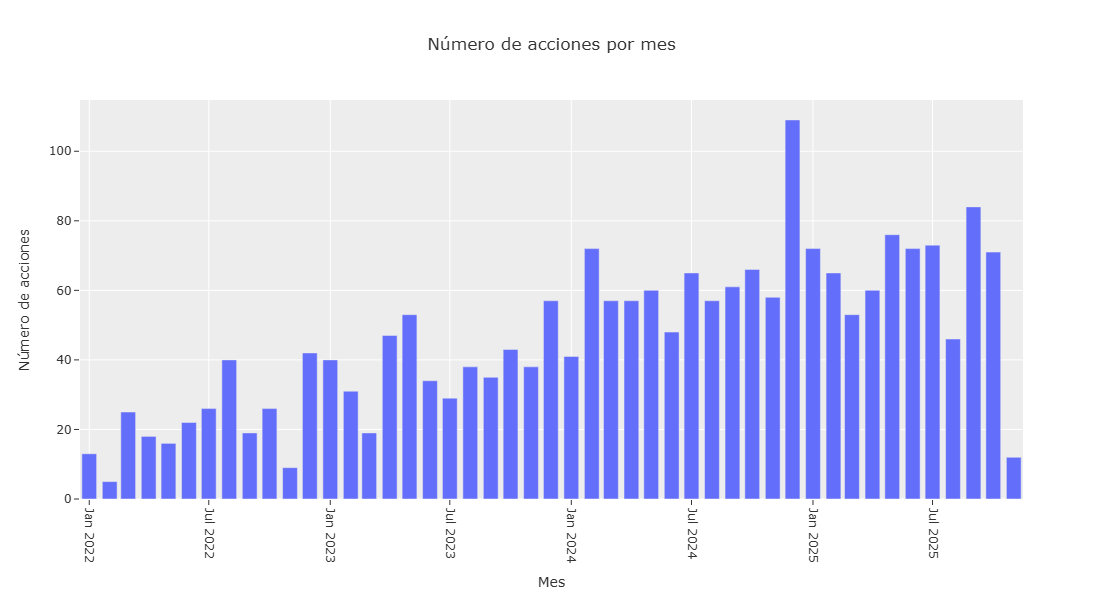

In [23]:
monthly_counts = (stocks_filtrados.groupby(['Period', 'Month']).size().reset_index(name='Stocks'))
monthly_counts['YearMonth'] = (monthly_counts['Period'].astype(str) + "-" + monthly_counts['Month'].astype(str).str.zfill(2))
monthly_counts = monthly_counts.sort_values(['Period', 'Month'])

fig = px.bar(
    monthly_counts,
    x = 'YearMonth',
    y = 'Stocks',
    hover_data = {
        'YearMonth': True,
        'Stocks': True
    },
    labels = {'Stocks': 'Número de acciones', 'YearMonth': 'Mes'},
    title = "Número de acciones por mes"
)

fig.update_layout(
    template = "ggplot2",
    height = 600,
    xaxis_tickangle = 90,
)

fig.show()

In [24]:
print(stocks_filtrados.shape)
stocks_filtrados.describe(include='all')

(2160, 11)


,Date,Ticker,Open Gap %,Day Return %,Open Price,Close Price,Premarket Volume,RTH Range %,Period,Month,Week
count,2160,2160,2160.000000,2160.000000,2160.000000,2160.000000,2.160000e+03,2160.000000,2160.000000,2160.000000,2160.0
unique,NaN,1078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
top,NaN,SPRC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
freq,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
mean,2024-05-13 04:36:00,NaN,1.308502,-0.061898,2.738778,2.546412,4.449359e+07,0.862564,2023.860185,6.581481,26.557407
min,2022-01-03 00:00:00,NaN,0.500086,-0.889086,0.010000,0.010000,1.009231e+06,0.102703,2022.000000,1.000000,1.0
25%,2023-08-20 06:00:00,NaN,0.623126,-0.267608,0.610000,0.520000,1.039660e+07,0.468038,2023.000000,4.000000,14.0
50%,2024-07-10 00:00:00,NaN,0.796480,-0.138931,1.910000,1.615000,2.135519e+07,0.666667,2024.000000,7.000000,27.0
75%,2025-03-05 06:00:00,NaN,1.167292,0.016098,3.970000,3.572500,4.518710e+07,0.989049,2025.000000,9.000000,39.0
max,2025-11-07 00:00:00,NaN,277.169014,4.976623,11.950000,41.000000,1.557433e+09,13.177285,2025.000000,12.000000,52.0


**Comprobamos la hipotesis inicial:**

* Las small caps tienden, estadísticamente, a perder valor con el tiempo tras movimientos extremos al alza."

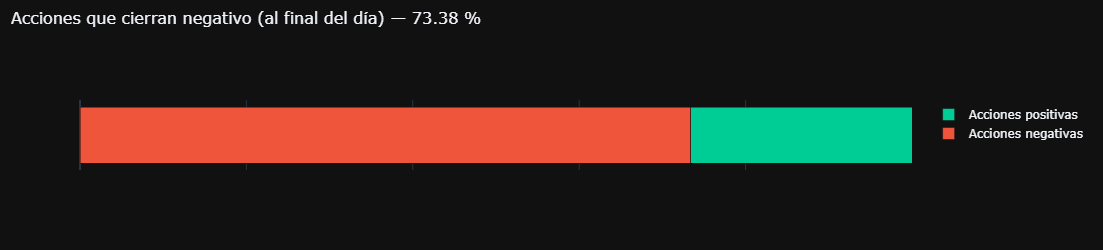

In [25]:
negativos = round((stocks_filtrados['Day Return %'] < 0).mean()*100, 2)

total = len(stocks_filtrados)
neg_count = (stocks_filtrados['Day Return %'] < 0).sum()
pos_count = total - neg_count

neg_pct = round(neg_count / total * 100, 2)
pos_pct = round(100 - neg_pct, 2)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=[neg_pct],
    y=[""],
    orientation = "h",
    marker = dict(color="#ef553b"),
    name = "Acciones negativas",
    hovertemplate = f"<b>Acciones negativas:</b> {neg_count}<br>%: {neg_pct}%<extra></extra>"
))

fig.add_trace(go.Bar(
    x = [pos_pct],
    y = [""],
    orientation = "h",
    marker = dict(color="#00cc96"),
    name="Acciones positivas",
    hovertemplate = f"<b>Acciones positivas:</b> {pos_count}<br>%: {pos_pct}%<extra></extra>"
))

fig.update_layout(
    barmode = "stack",
    template = "plotly_dark",
    height = 250,
    title = dict(
        text = f"Acciones que cierran negativo (al final del día) — {neg_pct} %",
        x = 0.01,
        y = 0.95,
        font = dict(size=16)
    ),
    showlegend = True
)

fig.update_xaxes(showticklabels=False, range=[0, 100])
fig.update_yaxes(showticklabels=False)

fig.show()

**Realizamos una exploración mas exhaustiva del sesgo estadístico negativo**

-Para ello volvemos al dataset original, y aplicamos el filtro prestablecido.

In [26]:
stocks_filtrados_1 = filtrar_smallcaps(stocks)
print(stocks_filtrados_1.shape)
stocks_filtrados_1.head()

(2160, 23)


,Date,Ticker,Open Gap %,RTH Run %,EOD Volume,Day Return %,Open Price,Low Spike Price,Close Price,Previous Day Close Price,...,PMH Gap %,PMH Fade to Open %,RTH Fade to Close %,RTH Range %,High Spike %,Low Spike %,HOD Time,LOD Time,PM High Time,VWAP at Open
7,2025-11-07,AZI,0.544073,0.000000,312587688,-0.378609,0.15,0.09,0.09,0.10,...,0.747720,-0.116522,-0.378609,0.691454,0.000000,-0.408793,09:30,15:15,08:32,0.15
22,2025-11-07,MSGM,1.079909,0.069133,105845068,-0.178924,4.55,3.16,3.74,2.19,...,1.648402,-0.214655,-0.232017,0.541059,0.069133,-0.306235,09:34,14:29,06:33,4.91
43,2025-11-06,BIYA,0.942370,0.253760,379462797,-0.107669,0.54,0.37,0.48,0.28,...,1.455926,-0.209109,-0.288276,0.815919,0.253760,-0.309573,09:45,12:48,08:21,0.55
51,2025-11-06,FTEL,0.535967,0.023460,64400870,-0.557185,3.41,1.45,1.51,2.22,...,1.319715,-0.337864,-0.567335,1.406897,0.023460,-0.574780,09:30,13:32,09:08,3.71
80,2025-11-05,CCTG,1.024078,0.000000,14798574,-0.633604,1.69,0.53,0.62,0.83,...,1.084332,-0.028908,-0.633604,2.188113,0.000000,-0.686335,09:30,14:50,09:29,1.40


In [27]:
#Calculamos la media
avg_return = round(stocks_filtrados_1['Day Return %'].mean()*100,2)
avg_open_gap = round(stocks_filtrados_1['Open Gap %'].mean()*100,2)
avg_high_spike = round(stocks_filtrados_1['High Spike %'].mean()*100,2)
avg_low_spike = round(stocks_filtrados_1['Low Spike %'].mean()*100,2)
avg_range = round(stocks_filtrados_1['RTH Range %'].mean()*100,2)

stocks_filtrados_1['HOD Time'] = pd.to_datetime(stocks_filtrados_1['HOD Time'], format="%H:%M", errors='coerce')
stocks_filtrados_1['HOD_horario'] = (stocks_filtrados_1['HOD Time'].dt.hour * 3600 + stocks_filtrados_1['HOD Time'].dt.minute * 60)
mean_seconds = stocks_filtrados_1['HOD_horario'].mean()
hours = int(mean_seconds // 3600)
minutes = int((mean_seconds % 3600) // 60)
avg_hod_time = f"{hours:02d}:{minutes:02d}"

stocks_filtrados_1['LOD Time'] = pd.to_datetime(stocks_filtrados_1['LOD Time'], format="%H:%M", errors='coerce')
stocks_filtrados_1['LOD_horario'] = (stocks_filtrados_1['LOD Time'].dt.hour * 3600 + stocks_filtrados_1['LOD Time'].dt.minute * 60)
mean_seconds = stocks_filtrados_1['LOD_horario'].mean()
hours = int(mean_seconds // 3600)
minutes = int((mean_seconds % 3600) // 60)
avg_lod_time = f"{hours:02d}:{minutes:02d}"

In [28]:
#Calculamos la mediana
median_return = round(stocks_filtrados_1['Day Return %'].median()*100,2)
median_open_gap = round(stocks_filtrados_1['Open Gap %'].median()*100,2)
median_high_spike = round(stocks_filtrados_1['High Spike %'].median()*100,2)
median_low_spike = round(stocks_filtrados_1['Low Spike %'].median()*100,2)
median_range = round(stocks_filtrados_1['RTH Range %'].median()*100,2)

stocks_filtrados_1['HOD Time'] = pd.to_datetime(stocks_filtrados_1['HOD Time'], format="%H:%M", errors='coerce')
stocks_filtrados_1['HOD_horario'] = (stocks_filtrados_1['HOD Time'].dt.hour * 3600 + stocks_filtrados_1['HOD Time'].dt.minute * 60)
mean_seconds = stocks_filtrados_1['HOD_horario'].median()
hours = int(mean_seconds // 3600)
minutes = int((mean_seconds % 3600) // 60)
median_hod_time = f"{hours:02d}:{minutes:02d}"

stocks_filtrados_1['LOD Time'] = pd.to_datetime(stocks_filtrados_1['LOD Time'], format="%H:%M", errors='coerce')
stocks_filtrados_1['LOD_horario'] = (stocks_filtrados_1['LOD Time'].dt.hour * 3600 + stocks_filtrados_1['LOD Time'].dt.minute * 60)
mean_seconds = stocks_filtrados_1['LOD_horario'].median()
hours = int(mean_seconds // 3600)
minutes = int((mean_seconds % 3600) // 60)
median_lod_time = f"{hours:02d}:{minutes:02d}"

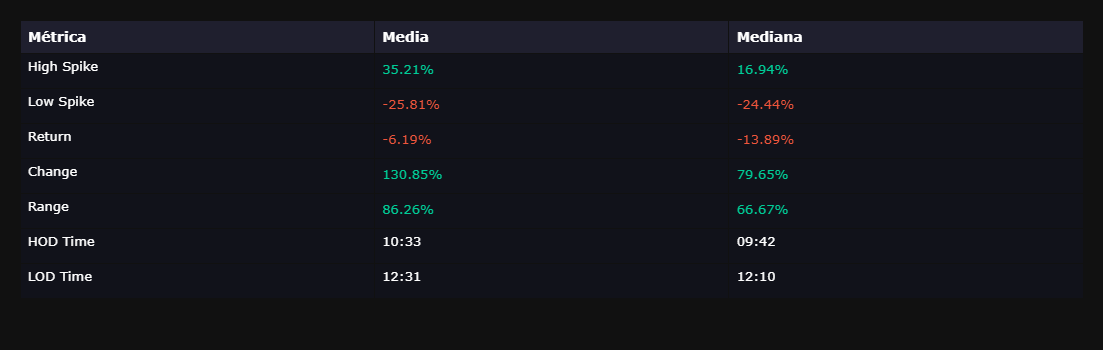

In [29]:
def format_value(v):
    if isinstance(v, str) and ":" in v:
        return v
    if v >= 0:
        return f"<span style='color:#00cc96'>{v}%</span>"
    else:
        return f"<span style='color:#ef553b'>{v}%</span>"

metrics = [
    "High Spike", "Low Spike", "Return",
    "Change", "Range", "HOD Time", "LOD Time"
]

avg_values = [
    format_value(avg_high_spike),
    format_value(avg_low_spike),
    format_value(avg_return),
    format_value(avg_open_gap),
    format_value(avg_range),
    avg_hod_time,
    avg_lod_time
]

median_values = [
    format_value(median_high_spike),
    format_value(median_low_spike),
    format_value(median_return),
    format_value(median_open_gap),
    format_value(median_range),
    median_hod_time,
    median_lod_time
]

fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=["<b>Métrica</b>", "<b>Media</b>", "<b>Mediana</b>"],
            fill_color="#1f1f2e",
            font=dict(color="white", size=14),
            align="left"
        ),
        cells=dict(
            values=[metrics, avg_values, median_values],
            fill_color="#11121A",
            align="left",
            font=dict(color="white", size=13),
            height=35,
            format=["", "", ""],
        )
    )
])

fig.update_layout(
    template="plotly_dark",
    height=350,
    margin=dict(t=20, b=20, l=20, r=20)
)

fig.show()

### Este panel revela un patrón muy consistente en el comportamiento de las acciones analizadas.

* La **mediana**, al no verse afectada por valores extremos, ofrece una visión más robusta del comportamiento típico. Según esta medida, las acciones tienden a cerrar aproximadamente en –14%, lo que refuerza la hipótesis de un sesgo bajista estructural en este tipo de activos.

* El **máximo intradía** (HOD) se alcanza alrededor de las 09:42, es decir, pocos minutos después de la apertura del mercado (09:30).

* El **mínimo intradía** (LOD) aparece cerca de las 12:10, lo que indica que, en promedio, el precio pierde fuerza de forma progresiva durante la mañana.

-En conjunto, estos datos sugieren que, tras la apertura, las acciones muestran un impulso inicial muy breve, seguido de una caída sostenida que culmina en mínimos alrededor del mediodía.

### La hipótesis gana fuerza cuando analizamos el retorno promedio por mes

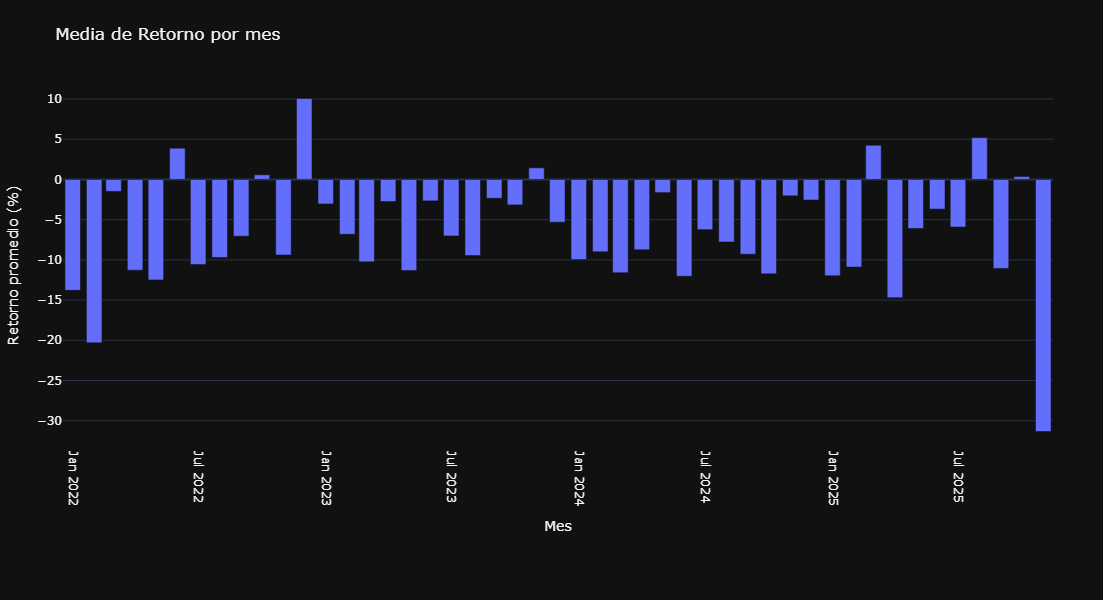

In [30]:
stocks_filtrados['Date'] = pd.to_datetime(stocks_filtrados['Date'])
stocks_filtrados['Year'] = stocks_filtrados['Date'].dt.year
stocks_filtrados['Month'] = stocks_filtrados['Date'].dt.month

monthly_return = (stocks_filtrados.groupby(['Year', 'Month'])['Day Return %'].mean().reset_index())
monthly_return['YearMonth'] = (monthly_return['Year'].astype(str) + "-" + monthly_return['Month'].astype(str).str.zfill(2))
monthly_return['Return (%)'] = round(monthly_return['Day Return %'] * 100, 2)
monthly_return[['YearMonth', 'Return (%)']]

fig = px.bar(
    monthly_return,
    x='YearMonth',
    y='Return (%)',
    title='Media de Retorno por mes',
    labels={'YearMonth': 'Mes', 'Return (%)': 'Retorno promedio (%)'},
    template='plotly_dark'
)

fig.update_layout(
    xaxis_tickangle=90,
    height=600,   
    width=1100,   
    margin=dict(l=50, r=50, t=80, b=150)
)

fig.show()

### Conclusión

Los resultados muestran un **comportamiento claramente bajista** en las small caps que presentan gaps significativos.
La mediana del retorno diario confirma que, en la mayoría de los casos, estas acciones **tienden a cerrar en negativo**.

Además, el máximo intradía se produce **muy cerca de la apertura**, mientras que el mínimo aparece **a media mañana**, lo que evidencia un patrón de agotamiento rápido seguido de una pérdida progresiva de valor.

En conjunto, estos elementos refuerzan la hipótesis de que este tipo de activos presenta un **sesgo estructural bajista**, consistente a lo largo del tiempo y potencialmente aprovechable.
